# Exploring the Effects of Different Degraders on Estimated Redshifts

**Authors:** Jennifer Scora

**Last run successfully:** Feb 4, 2025

In this notebook, we'll explore how to create simulated datasets with the [RAIL creation stage](https://descraildocs.z27.web.core.windows.net/source/rail_stages/creation.html), in particular focusing on how data sets created using different degradation algorithms can affect the training of models to estimate photometric redshifts (photo-zs). Here "degradation" algorithms refer to any algorithms applied to alter the "true" sample, for example to add biases or cuts. 

Here are the main steps we'll be following:

1. **Create the "true" data sets:** use an engine to sample tests and training data sets 
2. **Create "degraded" data sets:** 
    create multiple training data sets with different degradation algorithms, and one test data set with all the degradation algorithms used 
3. **Use the data sets to estimate redshifts:** 
    use the training data sets to train different models, and use each model on the same test data set  
4. **Evaluate the estimated redshift distributions and compare them:** 
    use the evaluator stages to calculate metrics for each model, and assess how certain degraders affect the resulting distributions

## 1. Create the "true" data sets

In this step we'll use the `PZFlow` engine to train a model, and sample from that model to create our "true" training and test data sets. 

### Set up

Let's start by importing the packages we'll need to create the data sets.

In [1]:
import rail.interactive as ri 
import numpy as np
import tables_io
from pzflow.examples import get_galaxy_data

# for plotting 
import matplotlib.pyplot as plt
%matplotlib inline

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


LEPHAREDIR is being set to the default cache directory:
/home/jscora/.cache/lephare/data
More than 1Gb may be written there.
LEPHAREWORK is being set to the default cache directory:
/home/jscora/.cache/lephare/work
Default work cache is already linked. 
This is linked to the run directory:
/home/jscora/.cache/lephare/runs/20250327T165906


We need to set up some column name dictionaries, as the expected column names vary between some of the codes. In order to handle this, we can pass in  dictionaries of expected column names and the column name that exists in the input data (`band_dict` and `rename_dict` below). In this notebook, we are using bands ugrizy, and each band will have a name 'mag_u_lsst', for example, with the error column name being 'mag_err_u_lsst'.

In [2]:
bands = ["u", "g", "r", "i", "z", "y"]
band_dict = {band: f"mag_{band}_lsst" for band in bands}
rename_dict = {f"mag_{band}_lsst_err": f"mag_err_{band}_lsst" for band in bands}

Now we can grab the galaxy data we'll use to train our creation model, and we'll rename the band columns to match our desired band names as discussed above, using `band_dict`. We can check that our columns have been renamed appropriately by printing out the first few lines of the table.

In [3]:
catalog = get_galaxy_data().rename(band_dict, axis=1)
# let's take a look at the columns
catalog.head()

,redshift,mag_u_lsst,mag_g_lsst,mag_r_lsst,mag_i_lsst,mag_z_lsst,mag_y_lsst
0,0.287087,26.759261,25.901778,25.187710,24.932318,24.736903,24.671623
1,0.293313,27.428358,26.679299,25.977161,25.700094,25.522763,25.417632
2,1.497276,27.294001,26.068798,25.450055,24.460507,23.887221,23.206112
3,0.283310,28.154075,26.283166,24.599570,23.723491,23.214108,22.860012
4,1.545183,29.276065,27.878301,27.333528,26.543374,26.061941,25.383056


Looks like the column names are the way we want them! 

### Train and sample the model

Now we need to use the galaxy data we retrieved to train the model that we'll use to create our input galaxy magnitude data catalogues later. We're going to use the `PZflow` engine to do this, specifically the `modeler` function. This will train the normalizing flow that serves as the engine for the input data creation. To get a sense of what it does and the parameters it needs, let's check out its docstrings:

In [4]:
ri.creation.engines.flowEngine.flow_modeler?

Signature:       ri.creation.engines.flowEngine.flow_modeler(**kwargs) -> Any
Call signature:  ri.creation.engines.flowEngine.flow_modeler(*args, **kwargs)
Type:            partial
String form:     functools.partial(<function _interactive_factory at 0x70ad1e1c8c20>, <class 'rail.creation.engines.flowEngine.FlowModeler'>, False, True)
File:            ~/software/anaconda3/envs/rail/lib/python3.12/functools.py
Docstring:      
Modeler wrapper for a PZFlow Flow object.

This class trains the flow.

---

Produce a creation model from which photometry and redshifts can be
generated.

---

This function was generated from the function
rail.creation.engines.flowEngine.FlowModeler.fit_model

Parameters
----------
input : DataHandle
    ???
seed : int, optional
    The random seed for training.
    Default: 0
phys_cols : dict, optional
    Names of non-photometry columns and their corresponding [min, max] values.
    Default: {'redshift': [0, 3]}
phot_cols : dict, optional
    Names of photomet

We'll pass the modeler a few parameters:
- **input:** this is the input catalog that our modeler needs to train the data flow (the one we retrieved above)
- **seed (optional):** this is the random seed used for training
- **phys_cols (optional):** The names of any non-photometry columns and their [min,max] values.
- **phot_cols (optional):** This is a dictionary of the names of the photometry columns and their corresponding [min,max] values.
- **calc_colors (optional):** Whether to internally calculate colors (if phot_cols are magnitudes). Assumes that you want to calculate colors from adjacent columns in phot_cols. If you do not want to calculate colors, set False. Else, provide a dictionary `{‘ref_column_name’: band}`, where band is a string corresponding to the column in phot_cols you want to save as the overall galaxy magnitude. We're passing in the default value here just so you can see how it works. 

In [5]:
flow_model = ri.creation.engines.flowEngine.flow_modeler(
    input=catalog,
    seed=0,
    phys_cols={"redshift": [0, 3]},
    phot_cols={
        "mag_u_lsst": [17, 35],
        "mag_g_lsst": [16, 32],
        "mag_r_lsst": [15, 30],
        "mag_i_lsst": [15, 30],
        "mag_z_lsst": [14, 29],
        "mag_y_lsst": [14, 28],
    },
    calc_colors={"ref_column_name": "mag_i_lsst"},
)

Inserting handle into data store.  input: None, FlowModeler
Training 30 epochs 
Loss:
(0) 21.3266
(1) 3.9686
(2) 1.9351
(3) 5.2006
(4) -0.3579
(5) 2.2561
(6) 1.5917
(7) 0.3691
(8) -1.0218
(9) inf
Training stopping after epoch 9 because training loss diverged.
Inserting handle into data store.  model: inprogress_model.pkl, FlowModeler


Now we'll use the flow to produce some synthetic data for our training data set and test data set. Since this is a test we'll create some small datasets, with 600 galaxies for this sample, so we'll pass in the argument: `n_samples = 600`. We'll also use a specific seed for each one to ensure they're reproducible but different from each other.

**Note that when we pass the model to this function, we don't pass the dictionary, but the actual model object. This is true of all the interactive functions.** 

In [26]:
# get sample test and training data sets
train_data_orig = ri.creation.engines.flowEngine.flow_creator(
    n_samples=600, model=flow_model["model"], seed=1235
)
test_data_orig = ri.creation.engines.flowEngine.flow_creator(
    model=flow_model["model"], n_samples=600, seed=1234
)

Inserting handle into data store.  model: <pzflow.flow.Flow object at 0x70abff117560>, FlowCreator
Inserting handle into data store.  output: inprogress_output.pq, FlowCreator
Inserting handle into data store.  model: <pzflow.flow.Flow object at 0x70abff117560>, FlowCreator
Inserting handle into data store.  output: inprogress_output.pq, FlowCreator


Let's plot these data sets to check that they are in fact different:

Text(0, 0.5, 'number of galaxies')

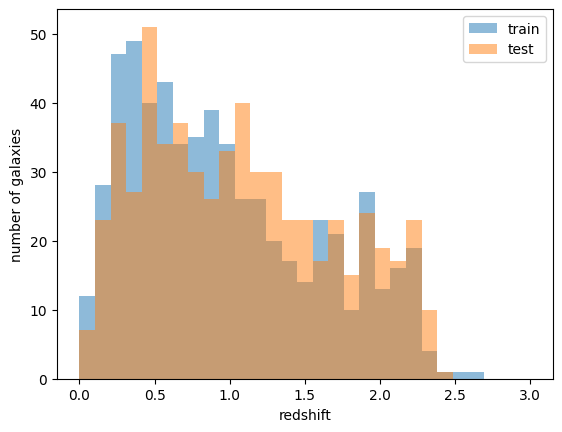

In [47]:
hist_options = {
    "bins": np.linspace(0,3,30),
    "histtype": "stepfilled",
    "alpha": 0.5
}

plt.hist(train_data_orig["output"]["redshift"],label="train", **hist_options)
plt.hist(test_data_orig["output"]["redshift"],label="test", **hist_options)
plt.legend(loc="best")
plt.xlabel("redshift")
plt.ylabel("number of galaxies")

## 2. Create "degraded" data sets by applying different sets of degraders

Let's make 4 different training data sets using increasingly more degraders, and one set of test data with all four degradations applied. The degraders we'll be using are:

1. `lsst_error_model` to add photometric errors that are modelled based on the telescope
2. `inv_redshift_incompleteness` to mimic redshift dependent incompleteness
3. `line_confusion` to simulate the effect of misidentified lines 
4. `quantity_cut` mimics a band-dependent brightness cut


### 1. LSST Error Model

This method adds photometric errors, non-detections and extended source errors that are modelled based on the Vera Rubin telescope. We're going to apply it to both training and test data sets. Once again, we're supplying different seeds to ensure the results are reproducible and different from each other. We need to supply the `band_dict` we created earlier, which tells the code what the band column names should be. We are also supplying `ndFlag=np.nan`, which just tells the code to make non-detections `np.nan` in the output. 

In [28]:
# training data
train_data_photerrs = ri.creation.degraders.photometric_errors.lsst_error_model(
    input=train_data_orig["output"], seed=66, renameDict=band_dict, ndFlag=np.nan
)

# test data set 
test_data_photerrs = ri.creation.degraders.photometric_errors.lsst_error_model(
    input=test_data_orig["output"], seed=66, renameDict=band_dict, ndFlag=np.nan
)

Inserting handle into data store.  input: None, LSSTErrorModel
Inserting handle into data store.  output: inprogress_output.pq, LSSTErrorModel
Inserting handle into data store.  input: None, LSSTErrorModel
Inserting handle into data store.  output: inprogress_output.pq, LSSTErrorModel


In [29]:
# let's see what the output looks like 
train_data_photerrs["output"].head()

,redshift,mag_u_lsst,mag_u_lsst_err,mag_g_lsst,mag_g_lsst_err,mag_r_lsst,mag_r_lsst_err,mag_i_lsst,mag_i_lsst_err,mag_z_lsst,mag_z_lsst_err,mag_y_lsst,mag_y_lsst_err
0,0.081514,21.600708,0.007486,20.599435,0.005083,19.996831,0.005023,19.694191,0.005033,19.587435,0.005082,19.553563,0.005326
1,1.982106,28.045543,1.087031,27.984741,0.463765,27.825487,0.367745,27.414988,0.410799,26.406834,0.331409,25.950067,0.473291
2,0.741412,24.239717,0.055593,24.456792,0.023063,24.182278,0.016138,23.614150,0.015944,23.513933,0.027296,23.499913,0.060768
3,0.873177,24.227208,0.054985,24.026876,0.016102,23.444153,0.009345,22.679293,0.008227,21.333696,0.006288,21.014948,0.008182
4,0.534689,24.932885,0.102129,24.096806,0.017046,23.026369,0.007389,22.655102,0.008117,22.539690,0.012207,22.390550,0.022870


You can see that the error columns have been added in for each of the magnitude columns. 

Now let's take a look at what's happened to the magnitudes. Below we'll plot the u-band magnitudes before and after running the degrader. You can see that the higher magnitude objects now have a much wider variance in magnitude compared to their initial magnitudes, but at lower magnitudes they've remained similar:

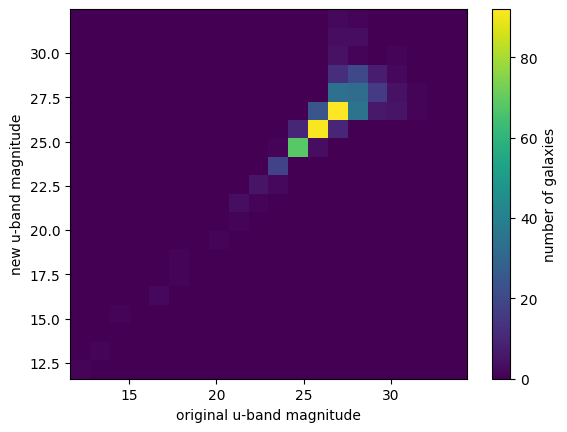

In [30]:
# we have to set the range because there are nans in the new dataset with errors, which messes up plt.hist2d 
range = [[np.min(train_data_orig["output"]["mag_u_lsst"]),np.max(train_data_orig["output"]["mag_u_lsst"])],
         [np.min(train_data_photerrs["output"]["mag_u_lsst"]),np.max(train_data_photerrs["output"]["mag_u_lsst"])]]
plt.hist2d(train_data_orig["output"]["mag_u_lsst"], train_data_photerrs["output"]["mag_u_lsst"], range=range, bins=20,cmap="viridis")
plt.xlabel("original u-band magnitude")
plt.ylabel("new u-band magnitude")
plt.colorbar(label="number of galaxies")

You can make this plot for all the other magnitudes if you'd like. 

### 2. Redshift Incompleteness 

This method applies a selection function, which keeps galaxies with probability $p_{\text{keep}}(z) = \min(1, \frac{z_p}{z})$, where $z_p$ is the ''pivot'' redshift. We'll use $z_p = 1.0$. 

**NOTE**:
This means that the output of the stage will have fewer galaxies than the input. We want to ensure that our degraded test data set matches our original "true" data set, so that the evaluation will be able to directly compare them. To do this, we can use the parameter `drop_rows=False`. This will return a data object of the same length as before, with a "flag" column that identifies which galaxies are to be kept, and which are to be dropped. 

In [31]:
# training data set
train_data_inc = ri.creation.degraders.spectroscopic_degraders.inv_redshift_incompleteness(input=train_data_photerrs["output"], pivot_redshift=1.0)

# test data set - use drop_rows to ensure it's the same length
test_data_inc = ri.creation.degraders.spectroscopic_degraders.inv_redshift_incompleteness(input=test_data_photerrs["output"], pivot_redshift=1.0, drop_rows=False)
test_data_inc["output"] # look at the output 

Inserting handle into data store.  input: None, InvRedshiftIncompleteness
Inserting handle into data store.  output: inprogress_output.pq, InvRedshiftIncompleteness
Inserting handle into data store.  input: None, InvRedshiftIncompleteness
Inserting handle into data store.  output: inprogress_output.pq, InvRedshiftIncompleteness


,flag,redshift,mag_u_lsst,mag_u_lsst_err,mag_g_lsst,mag_g_lsst_err,mag_r_lsst,mag_r_lsst_err,mag_i_lsst,mag_i_lsst_err,mag_z_lsst,mag_z_lsst_err,mag_y_lsst,mag_y_lsst_err
0,True,1.500731,27.327925,0.690722,26.899576,0.194670,26.207932,0.094688,24.808363,0.044780,24.061702,0.044247,23.386367,0.054944
1,True,0.682672,25.564077,0.175793,25.176035,0.043255,24.187701,0.016209,23.108187,0.010819,22.590246,0.012682,22.393191,0.022922
2,True,0.455805,25.981842,0.249102,25.137462,0.041805,23.888543,0.012789,23.027964,0.010232,23.155412,0.020043,22.560541,0.026497
3,True,0.204584,26.665431,0.428144,25.521004,0.058709,25.164164,0.037582,24.908816,0.048957,25.142341,0.114873,24.738585,0.178975
4,True,2.212477,25.031834,0.111311,25.259114,0.046555,24.959180,0.031362,24.939079,0.050291,24.629825,0.073232,24.658285,0.167169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,False,1.313742,26.105761,0.275612,25.647061,0.065638,25.099374,0.035489,24.602969,0.037326,23.897265,0.038246,23.516272,0.061656
596,True,1.477437,26.014074,0.255770,26.204217,0.107148,26.180117,0.092403,25.905911,0.117975,25.496396,0.155976,25.071949,0.236618
597,True,1.004496,25.359990,0.147745,24.988251,0.036645,24.471222,0.020540,24.032061,0.022649,23.365492,0.023993,23.229185,0.047788
598,True,0.533877,24.667860,0.081003,24.216727,0.018823,23.358627,0.008859,22.926082,0.009559,22.752432,0.014386,22.609100,0.027643


We can see that, as expected, the test data set has the "flag" column, and that the length of the data set is still 600. Now let's take a look at the training data set, where we left `drop_rows` as true:

In [32]:
train_data_inc["output"] # look at the output 

,redshift,mag_u_lsst,mag_u_lsst_err,mag_g_lsst,mag_g_lsst_err,mag_r_lsst,mag_r_lsst_err,mag_i_lsst,mag_i_lsst_err,mag_z_lsst,mag_z_lsst_err,mag_y_lsst,mag_y_lsst_err
0,0.081514,21.600708,0.007486,20.599435,0.005083,19.996831,0.005023,19.694191,0.005033,19.587435,0.005082,19.553563,0.005326
2,0.741412,24.239717,0.055593,24.456792,0.023063,24.182278,0.016138,23.614150,0.015944,23.513933,0.027296,23.499913,0.060768
3,0.873177,24.227208,0.054985,24.026876,0.016102,23.444153,0.009345,22.679293,0.008227,21.333696,0.006288,21.014948,0.008182
4,0.534689,24.932885,0.102129,24.096806,0.017046,23.026369,0.007389,22.655102,0.008117,22.539690,0.012207,22.390550,0.022870
6,0.694544,26.548970,0.391600,25.830116,0.077157,25.075605,0.034751,24.459512,0.032884,24.255343,0.052544,24.125111,0.105461
...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,1.827520,NaN,NaN,28.564051,0.701622,27.568611,0.299993,27.098209,0.320652,25.417800,0.145805,26.236930,0.583466
596,0.789594,26.969790,0.536834,27.603759,0.345976,27.147304,0.212318,26.528591,0.201047,26.007307,0.239788,26.194979,0.566227
597,1.055365,26.709837,0.442794,26.679047,0.161480,25.869220,0.070238,25.364239,0.073322,24.475552,0.063882,24.367767,0.130250
598,0.579771,26.136466,0.282555,26.214452,0.108109,25.535501,0.052243,25.233874,0.065329,25.139298,0.114569,24.849029,0.196470


This data set is shorter than the test data set now, since those galaxies have just been removed from the data entirely. This isn't a problem for the training data set, since we don't need to compare it to anything later. Let's plot a histogram of the training data set redshifts with just the photometric errors, and compare it to our new data set with both that and the redshift incompleteness:

Text(0, 0.5, 'number of galaxies')

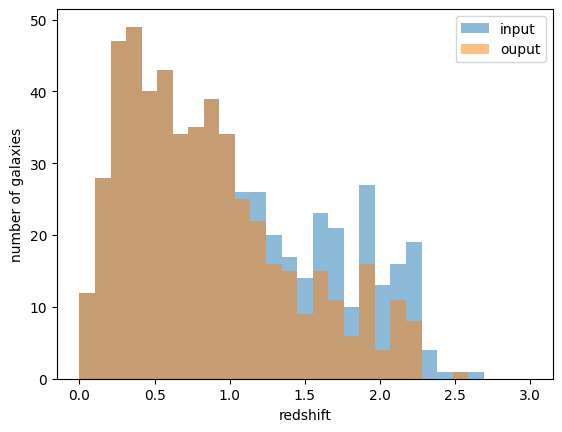

In [48]:
plt.hist(train_data_photerrs["output"]["redshift"],label="input", **hist_options)
plt.hist(train_data_inc["output"]["redshift"],label="ouput", **hist_options)
plt.legend(loc="best")
plt.xlabel("redshift")
plt.ylabel("number of galaxies")

The output data set clearly has fewer galaxies than the input data set above redshift of 1, and the distributions are the same for redshifts less than 1, as expected. 

For the test data set, we just have one more step that we need to do before we can feed it into any other degraders. We use the "flag" column to mask all of the "dropped" galaxy rows and set them all as `np.nan` - this keeps the indices the same, allowing us to compare to the truth data set as is our goal.  

In [34]:
# save the column as a separate variable 
inc_flag = test_data_inc["output"]["flag"]

# drop the flag column from the dataframe entirely 
test_data_inc["output"].drop(columns="flag",inplace=True)

# replace the lines that are cut out by the degrader with np.nan  
new_test_data_inc = test_data_inc["output"].where(inc_flag, np.nan)

# take a look at the result
new_test_data_inc

,redshift,mag_u_lsst,mag_u_lsst_err,mag_g_lsst,mag_g_lsst_err,mag_r_lsst,mag_r_lsst_err,mag_i_lsst,mag_i_lsst_err,mag_z_lsst,mag_z_lsst_err,mag_y_lsst,mag_y_lsst_err
0,1.500731,27.327925,0.690722,26.899576,0.194670,26.207932,0.094688,24.808363,0.044780,24.061702,0.044247,23.386367,0.054944
1,0.682672,25.564077,0.175793,25.176035,0.043255,24.187701,0.016209,23.108187,0.010819,22.590246,0.012682,22.393191,0.022922
2,0.455805,25.981842,0.249102,25.137462,0.041805,23.888543,0.012789,23.027964,0.010232,23.155412,0.020043,22.560541,0.026497
3,0.204584,26.665431,0.428144,25.521004,0.058709,25.164164,0.037582,24.908816,0.048957,25.142341,0.114873,24.738585,0.178975
4,2.212477,25.031834,0.111311,25.259114,0.046555,24.959180,0.031362,24.939079,0.050291,24.629825,0.073232,24.658285,0.167169
...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
596,1.477437,26.014074,0.255770,26.204217,0.107148,26.180117,0.092403,25.905911,0.117975,25.496396,0.155976,25.071949,0.236618
597,1.004496,25.359990,0.147745,24.988251,0.036645,24.471222,0.020540,24.032061,0.022649,23.365492,0.023993,23.229185,0.047788
598,0.533877,24.667860,0.081003,24.216727,0.018823,23.358627,0.008859,22.926082,0.009559,22.752432,0.014386,22.609100,0.027643


The new dataframe is the same length as the old one, but without the flag column, and now those rows will just be `np.nan`. 



### 3. Line Confusion

This method simulates the effect of misidentified lines. The degrader will misidentify some percentage (`frac_wrong`) of the actual lines (here we're picking `5007.0` Angstroms, which are OIII lines) as the line we pick for `wrong_wavelen`. In this case, we'll pick `3727.0` Angstroms, which are OII lines. 

This degrader doesn't cut any galaxies, so we don't have to worry about the `drop_rows` parameter. 

In [35]:
# dataset 3: add in line confusion
train_data_conf = ri.creation.degraders.spectroscopic_degraders.line_confusion(
    input=train_data_inc["output"],
    true_wavelen=5007.0,
    wrong_wavelen=3727.0,
    frac_wrong=0.05,
    seed=1337,
)

# dataset 3: add in line confusion using the modified data set 
test_data_conf = ri.creation.degraders.spectroscopic_degraders.line_confusion(
    input=new_test_data_inc,
    true_wavelen=5007.0,
    wrong_wavelen=3727.0,
    frac_wrong=0.05,
    seed=1450,
)

Inserting handle into data store.  input: None, LineConfusion
Inserting handle into data store.  output: inprogress_output.pq, LineConfusion
Inserting handle into data store.  input: None, LineConfusion
Inserting handle into data store.  output: inprogress_output.pq, LineConfusion


Now let's take a look at what this has done to our redshift distribution by plotting the input training data set against the one output by the `line_confusion` method:

Text(0, 0.5, 'number of galaxies')

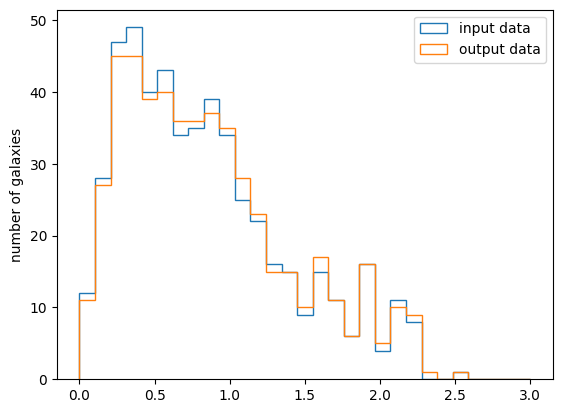

In [ ]:
plt.hist(train_data_inc["output"]["redshift"],label="input data", **hist_options)
plt.hist(train_data_conf["output"]["redshift"],label="output data", **hist_options)
plt.legend(loc="best")
plt.ylabel("redshift")
plt.ylabel("number of galaxies")

We can see that the output data has a few small differences in the distribution, spread across the whole range of redshifts. 

### 4. Quantity Cut

 This method cuts galaxies based on their band magnitudes. It takes a dictionary of cuts, where you can provide the band name and the values to cut that band on (for example, `{"mag_i_lsst": 25.0}`). If one value is given, it's considered a maximum, and if a tuple is given, it's considered a range within which the sample is selected. For this, we'll just set a maximum magnitude for the i band of 25.

 Since this method cuts galaxies, we're going to follow the steps we used for the `inv_redshift_incompleteness` method to keep our test dataset at the same length:

In [37]:
# cut some of the data below a certain magnitude 
train_data_cut = ri.creation.degraders.quantityCut.quantity_cut(
    input=train_data_conf["output"], cuts={"mag_i_lsst": 25.0}
)

# cut some of the data below a certain magnitude, set drop_rows=False to keep data set the same length
test_data_cut = ri.creation.degraders.quantityCut.quantity_cut(
    input=test_data_conf["output"], cuts={"mag_i_lsst": 25.0}, drop_rows=False
)
test_data_cut["output"]

Inserting handle into data store.  input: None, QuantityCut
Inserting handle into data store.  output: inprogress_output.pq, QuantityCut
Inserting handle into data store.  input: None, QuantityCut
Inserting handle into data store.  output: inprogress_output.pq, QuantityCut


,flag,redshift,mag_u_lsst,mag_u_lsst_err,mag_g_lsst,mag_g_lsst_err,mag_r_lsst,mag_r_lsst_err,mag_i_lsst,mag_i_lsst_err,mag_z_lsst,mag_z_lsst_err,mag_y_lsst,mag_y_lsst_err
0,1,1.500731,27.327925,0.690722,26.899576,0.194670,26.207932,0.094688,24.808363,0.044780,24.061702,0.044247,23.386367,0.054944
1,1,0.682672,25.564077,0.175793,25.176035,0.043255,24.187701,0.016209,23.108187,0.010819,22.590246,0.012682,22.393191,0.022922
2,1,0.455805,25.981842,0.249102,25.137462,0.041805,23.888543,0.012789,23.027964,0.010232,23.155412,0.020043,22.560541,0.026497
3,1,0.204584,26.665431,0.428144,25.521004,0.058709,25.164164,0.037582,24.908816,0.048957,25.142341,0.114873,24.738585,0.178975
4,1,2.212477,25.031834,0.111311,25.259114,0.046555,24.959180,0.031362,24.939079,0.050291,24.629825,0.073232,24.658285,0.167169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
596,0,2.328287,26.014074,0.255770,26.204217,0.107148,26.180117,0.092403,25.905911,0.117975,25.496396,0.155976,25.071949,0.236618
597,1,1.004496,25.359990,0.147745,24.988251,0.036645,24.471222,0.020540,24.032061,0.022649,23.365492,0.023993,23.229185,0.047788
598,1,0.533877,24.667860,0.081003,24.216727,0.018823,23.358627,0.008859,22.926082,0.009559,22.752432,0.014386,22.609100,0.027643


We can see that there's been a flag column added to the test data again, but this time the flags are 1 and 0 instead of True and False. Let's do the same as we did before, and drop the flag column from the dataframe and use it to turn all dropped rows into `np.nan`:

In [38]:
# save flag column
cut_flag = test_data_cut["output"]["flag"]

# drop flag column from dataframe
test_data_cut["output"].drop(columns="flag",inplace=True) 

# set all lines cut by the degrader to nans 
new_test_data_cut = test_data_cut["output"].where(cut_flag == 1, np.nan)

# let's see the new data 
new_test_data_cut

,redshift,mag_u_lsst,mag_u_lsst_err,mag_g_lsst,mag_g_lsst_err,mag_r_lsst,mag_r_lsst_err,mag_i_lsst,mag_i_lsst_err,mag_z_lsst,mag_z_lsst_err,mag_y_lsst,mag_y_lsst_err
0,1.500731,27.327925,0.690722,26.899576,0.194670,26.207932,0.094688,24.808363,0.044780,24.061702,0.044247,23.386367,0.054944
1,0.682672,25.564077,0.175793,25.176035,0.043255,24.187701,0.016209,23.108187,0.010819,22.590246,0.012682,22.393191,0.022922
2,0.455805,25.981842,0.249102,25.137462,0.041805,23.888543,0.012789,23.027964,0.010232,23.155412,0.020043,22.560541,0.026497
3,0.204584,26.665431,0.428144,25.521004,0.058709,25.164164,0.037582,24.908816,0.048957,25.142341,0.114873,24.738585,0.178975
4,2.212477,25.031834,0.111311,25.259114,0.046555,24.959180,0.031362,24.939079,0.050291,24.629825,0.073232,24.658285,0.167169
...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
597,1.004496,25.359990,0.147745,24.988251,0.036645,24.471222,0.020540,24.032061,0.022649,23.365492,0.023993,23.229185,0.047788
598,0.533877,24.667860,0.081003,24.216727,0.018823,23.358627,0.008859,22.926082,0.009559,22.752432,0.014386,22.609100,0.027643


We can see that the dataframe still has 600 rows, and now some of those rows are all NaNs, as we were aiming for. But it's cut out quite a few galaxies. Let's plot a histogram of the training data set we input into the `quantity_cut` method compared to the output training data set to see how it's changed the number and distribution of galaxies:

Text(0, 0.5, 'number of galaxies')

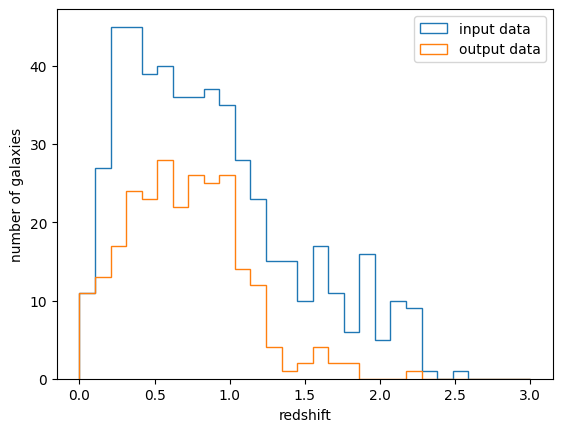

In [39]:
plt.hist(train_data_conf["output"]["redshift"],label="input data", **hist_options)
plt.hist(train_data_cut["output"]["redshift"],label="output data", **hist_options)
plt.legend(loc="best")
plt.xlabel("redshift")
plt.ylabel("number of galaxies")

We can see our output distribution has roughly the same shape, but with significantly fewer galaxies overall. 

Now we have applied four different degraders, so we've set up our various training data sets, and our test data set. The final step is to use the dictionary we made earlier of error column names (`rename_dict`) to rename the error columns, so they match the expected names for the later steps:

In [40]:
# renames error columns to match DC2 for training data sets

# photerrs
df_train_data_photerrs = ri.tools.table_tools.column_mapper(
    input=train_data_photerrs["output"], columns=rename_dict
)

# photerrs
df_train_data_inc = ri.tools.table_tools.column_mapper(
    input=train_data_inc["output"], columns=rename_dict
)

# photerrs
df_train_data_conf = ri.tools.table_tools.column_mapper(
    input=train_data_conf["output"], columns=rename_dict
)

# photerrs
df_train_data_cut = ri.tools.table_tools.column_mapper(
    input=train_data_cut["output"], columns=rename_dict
)


# renames error columns for test data set 
df_test_data = ri.tools.table_tools.column_mapper(input=new_test_data_cut, columns=rename_dict)

Inserting handle into data store.  input: None, ColumnMapper
Inserting handle into data store.  output: inprogress_output.pq, ColumnMapper
Inserting handle into data store.  input: None, ColumnMapper
Inserting handle into data store.  output: inprogress_output.pq, ColumnMapper
Inserting handle into data store.  input: None, ColumnMapper
Inserting handle into data store.  output: inprogress_output.pq, ColumnMapper
Inserting handle into data store.  input: None, ColumnMapper
Inserting handle into data store.  output: inprogress_output.pq, ColumnMapper
Inserting handle into data store.  input: None, ColumnMapper
Inserting handle into data store.  output: inprogress_output.pq, ColumnMapper


Text(0, 0.5, 'number of galaxies')

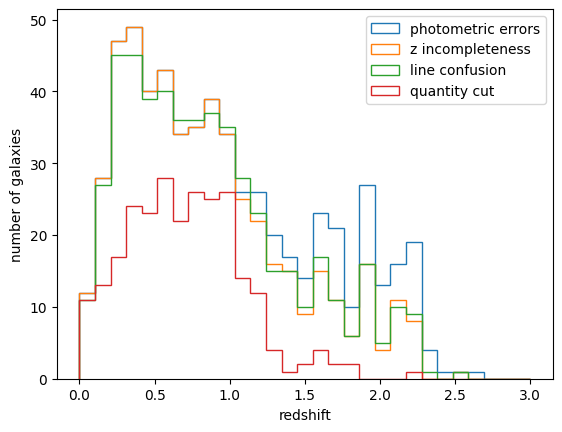

In [45]:
plt.hist(df_train_data_photerrs["output"]["redshift"],label="photometric errors", **hist_options)
plt.hist(df_train_data_inc["output"]["redshift"],label="z incompleteness", **hist_options)
plt.hist(df_train_data_conf["output"]["redshift"],label="line confusion", **hist_options)
plt.hist(df_train_data_cut["output"]["redshift"],label="quantity cut", **hist_options)

plt.legend(loc="best")
plt.xlabel("redshift")
plt.ylabel("number of galaxies")

These are all four of our different training data sets plotted together, so we can see how they compare. Now let's take them and use them to estimate our redshifts.

## 3. Use the data sets to estimate redshifts

In this step, we'll use all four of our training data sets to train our models, which means we'll be putting them into the "inform" method of our estimation algorithm. For this notebook, we'll use the [K-Nearest Neighbours](https://rail-hub.readthedocs.io/en/latest/source/estimators.html#k-nearest-neighbor) (KNN) algorithm. For more details on how this algorithm works, you can see the [wikipedia page] or [00_Quick_start_in_Estimation]. 

First, we'll set up a dictionary with all the training datasets, and empty dictionaries to store the estimated redshift distributions. 

In [ ]:
# make a dictionary of the training datasets to iterate through 
train_datasets = {"lsst_error_model":df_train_data_photerrs, "inv_redshift_incompleteness":df_train_data_inc, "line_confusion": df_train_data_conf, "quantity_cut": df_train_data_cut}

# set up dictionary for output
photo_zs = {}


In [ ]:
for key, df in train_datasets.items():

    # train the model
    inform_knn = ri.estimation.algos.k_nearneigh.k_near_neigh_informer(
        input=df["output"], nondetect_val=np.nan, hdf5_groupname=""
    )
    # estimate the photozs 
    knn_estimated = ri.estimation.algos.k_nearneigh.k_near_neigh_estimator(
    input=df_test_data,
    model=inform_knn["model"],
    nondetect_val=np.nan,
    hdf5_groupname="",
    )
    photo_zs[key] = knn_estimated

In [ ]:
# set up dictionaries for output 
point_est_list = {}
eval_list = {}

for key, df in train_datasets.items():

    # summarize the distributions
    point_estimate_ens = ri.estimation.algos.point_est_hist.point_est_hist_summarizer(
    input=photo_zs[key]["output"]
    )
    point_est_list[key] = point_estimate_ens

    # evaluate the results 
    evaluator_stage_dict = dict(
        metrics=["cdeloss", "brier"],
        _random_state=None,
        metric_config={
            "brier": {"limits": (0, 3.1)},
        },
    )

    the_eval = ri.evaluation.dist_to_point_evaluator.dist_to_point_evaluator(
            input={"data": photo_zs[key]["output"], "truth": test_data_orig["output"]
            },
            **evaluator_stage_dict,
            hdf5_groupname="",
        )
    
    # put the evaluation results in a dictionary so we have them 
    eval_list[key] = the_eval


In [ ]:
eval_list[0]